# <center>Convolutional Neural Networks</center>
## <center>Inclass Project 4 - MA4144</center>

This project contains 5 tasks/questions to be completed, some require written answers. Open a markdown cell below the respective question that require written answers and provide (type) your answers. Questions that required written answers are given in blue fonts. Almost all written questions are open ended, they do not have a correct or wrong answer. You are free to give your opinions, but please provide related answers within the context.

After finishing project run the entire notebook once and **save the notebook as a pdf** (File menu -> Save and Export Notebook As -> PDF). You are **required to upload both the PDF and the ipynb file on moodle**.

***

## Outline of the project

The aim of the project is to practically learn and implement about CNN. This project will have two main sections.

Section 1: Build a convolutional layer and pooling layer from scratch. Then test them on a sample image.

Section 2: Use the Keras library to implement a CNN to classify images on the [CIFAR10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).

***


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from keras.preprocessing.image import load_img
import keras
from scipy import signal
from PIL import Image
from keras import layers
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support,classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import torch


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/Users/garthigan.k/Desktop/Academics /Sem 8/Neural Networks/Project 4/keras/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/garthigan.k/Desktop/Academics 

## Section 1: Convolution and Pooling

**Q1** In the following cell, implement a method called create_padding. The method will take in input_image ($n \times m$) and will return a zero-padded image called output_image of dimension $(n + 2d) \times (m + 2d)$ where $d$ is the padding thickness on either side.

In [2]:
def create_padding(input_image, d):
    # Get dimensions of input image
    n, m = input_image.shape

    # Create output image with padded dimensions
    output_image = np.zeros((n + 2*d, m + 2*d))

    # Copy input image to the center of the padded image
    output_image[d:n+d, d:m+d] = input_image

    return output_image

**Q2** In the following cell, implement a method called convolution. The method will take in input_image ($n \times m$), kernel ($k \times k$) and will return output_image of dimension $(n - k + 1) \times (m - k + 1)$. The output_image is the result of the convolution between input_image and kernel. You may assume that the stride is $1$.

In [3]:
def convolution(input_image, kernel):
    # Get dimensions
    n, m = input_image.shape
    k = kernel.shape[0]  # Assuming square kernel (k x k)

    # Calculate output dimensions
    output_height = n - k + 1
    output_width = m - k + 1

    # Initialize output image
    output_image = np.zeros((output_height, output_width),dtype=float)

    # Perform convolution
    for i in range(output_height):
        for j in range(output_width):
            # Extract the region of interest from input image
            region = input_image[i:i+k, j:j+k]
            # Compute element-wise multiplication and sum
            output_image[i, j] = np.sum(region * kernel)

    return output_image

**Q3** In the following cell, implement a method called pooling. The method will take in input_image ($n \times m$), $p$ the pooling dimension, pooling_type (either max_pooling or avg_pooling) and will return output_image of dimension $(n - p + 1) \times (m - p + 1)$. The output_image is the result of performing pooling on input_image by a window of dimension $p \times p$. You may assume that the stride is $1$.

In [4]:
def pooling(input_image, p, pooling_type="max_pooling"):
    # Get input image dimensions
    n, m = input_image.shape

    # Calculate output dimensions
    output_height = n - p + 1
    output_width = m - p + 1

    # Initialize output image
    output_image = np.zeros((output_height, output_width),dtype=float)

    if pooling_type == "max_pooling":
        # Perform max pooling
        for i in range(output_height):
            for j in range(output_width):
                # Extract p x p region
                region = input_image[i:i+p, j:j+p]
                # Compute maximum value in the region
                output_image[i, j] = np.max(region)

    elif pooling_type == "avg_pooling":
        # Perform average pooling
        for i in range(output_height):
            for j in range(output_width):
                # Extract p x p region
                region = input_image[i:i+p, j:j+p]
                # Compute average value in the region
                output_image[i, j] = np.mean(region)

    else:
        print("Error: Invalid pooling type")
        return None

    return output_image

The 'lena' image is widely used for image processing experiments and has been a benchmark image until recently.
We will use a $512 \times 512$ grayscale lena sample to test our convolution and pooling implementations.

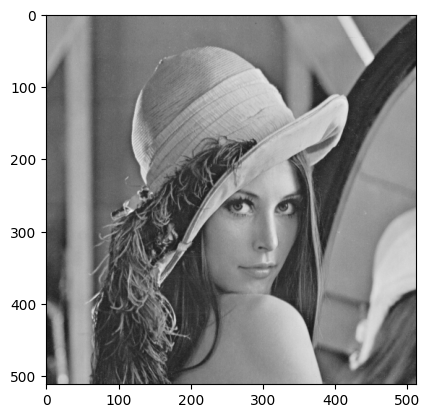

In [5]:
lena = load_img('lena.gif')
plt.imshow(lena)
plt.show()

**Q4** In the following perform convolution on lena. Make sure you use padding appropriately to maintain the image size after convolution. However, pooling should be done on an unpadded image and image size may not be preseved after pooling. Use the following kernels to perform convolution and pooling separately.

1. $\begin{bmatrix} +1 & 0 & -1 \\ +1 & 0 & -1 \\ +1 & 0 & -1 \end{bmatrix}$
   
2. $\begin{bmatrix} -1 & -1 & -1 \\ 0 & 0 & 0 \\ +1 & +1 & +1 \end{bmatrix}$

3. $\begin{bmatrix} -1 & 0 & +1 \\ -2 & 0 & +2 \\ -1 & 0 & +1 \end{bmatrix}$

4. $\begin{bmatrix} +1 & +2 & +1 \\ 0 & 0 & 0 \\ -1 & -2 & -1 \end{bmatrix}$

5. Any other kernel that you may find interesting.

The following outputs are expected:
1. lena kernel 1 convolution and then max pooled, set your output to the variable lena_kernel_1_maxpool.
2. lena kernel 2 convolution and then average pooled, set your output to the variable lena_kernel_2_avgpool.
3. lena kernel 3 convolution and then max pooled, set your output to the variable lena_kernel_3_maxpool.
4. lena kernel 4 convolution and then average pooled, set your output to the variable lena_kernel_4_avgpool.

In [6]:
lena_array = np.array(lena.convert('L'))


kernel_1 = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
kernel_2 = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])
kernel_3 = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
kernel_4 = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
kernel_5 = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]]) / 16

kernel_size = 3
padding_thickness = kernel_size // 2
padded_lena = create_padding(lena_array, padding_thickness)


conv_1 = convolution(padded_lena, kernel_1)
conv_2 = convolution(padded_lena, kernel_2)
conv_3 = convolution(padded_lena, kernel_3)
conv_4 = convolution(padded_lena, kernel_4)
conv_5 = convolution(padded_lena, kernel_5)

pool_size = 2
lena_kernel_1_maxpool = pooling(conv_1, pool_size, "max_pooling")
lena_kernel_2_avgpool = pooling(conv_2, pool_size, "avg_pooling")
lena_kernel_3_maxpool = pooling(conv_3, pool_size, "max_pooling")
lena_kernel_4_avgpool = pooling(conv_4, pool_size, "avg_pooling")
lena_kernel_5_maxpool = pooling(conv_5, pool_size, "max_pooling")  

<font color='blue'>Explain what each of the above kernels (including your choice) will do to the image.</font>

In [7]:
#Write your answers as a string (max 2 sentences per kernel)

Ans_Kernel_1 = "Highlights vertical boundaries (like the sides of Lena's face), while max pooling strengthens prominent features for a crisp edge representation."
Ans_Kernel_2 = "Captures horizontal transitions (such as the edge of Lena’s hat), and average pooling softens these features, giving a more blended appearance."
Ans_Kernel_3 = "Uses Sobel filtering to better detect vertical edges, with max pooling enhancing prominent lines and reducing sensitivity to noise compared to Kernel 1."
Ans_Kernel_4 = "Applies Sobel filtering to bring out horizontal edges, with average pooling yielding a smoother image that maintains improved edge definition."
Ans_Kernel_5 = "Applies Gaussian blur to suppress fine details and noise, while max pooling selects the brightest regions, subtly preserving contrast in a softened image."


Show the resulting image after convolution and pooling separately on two subplots (of the same plot) for each kernel. There should be 5 plots with two sub plots in each.

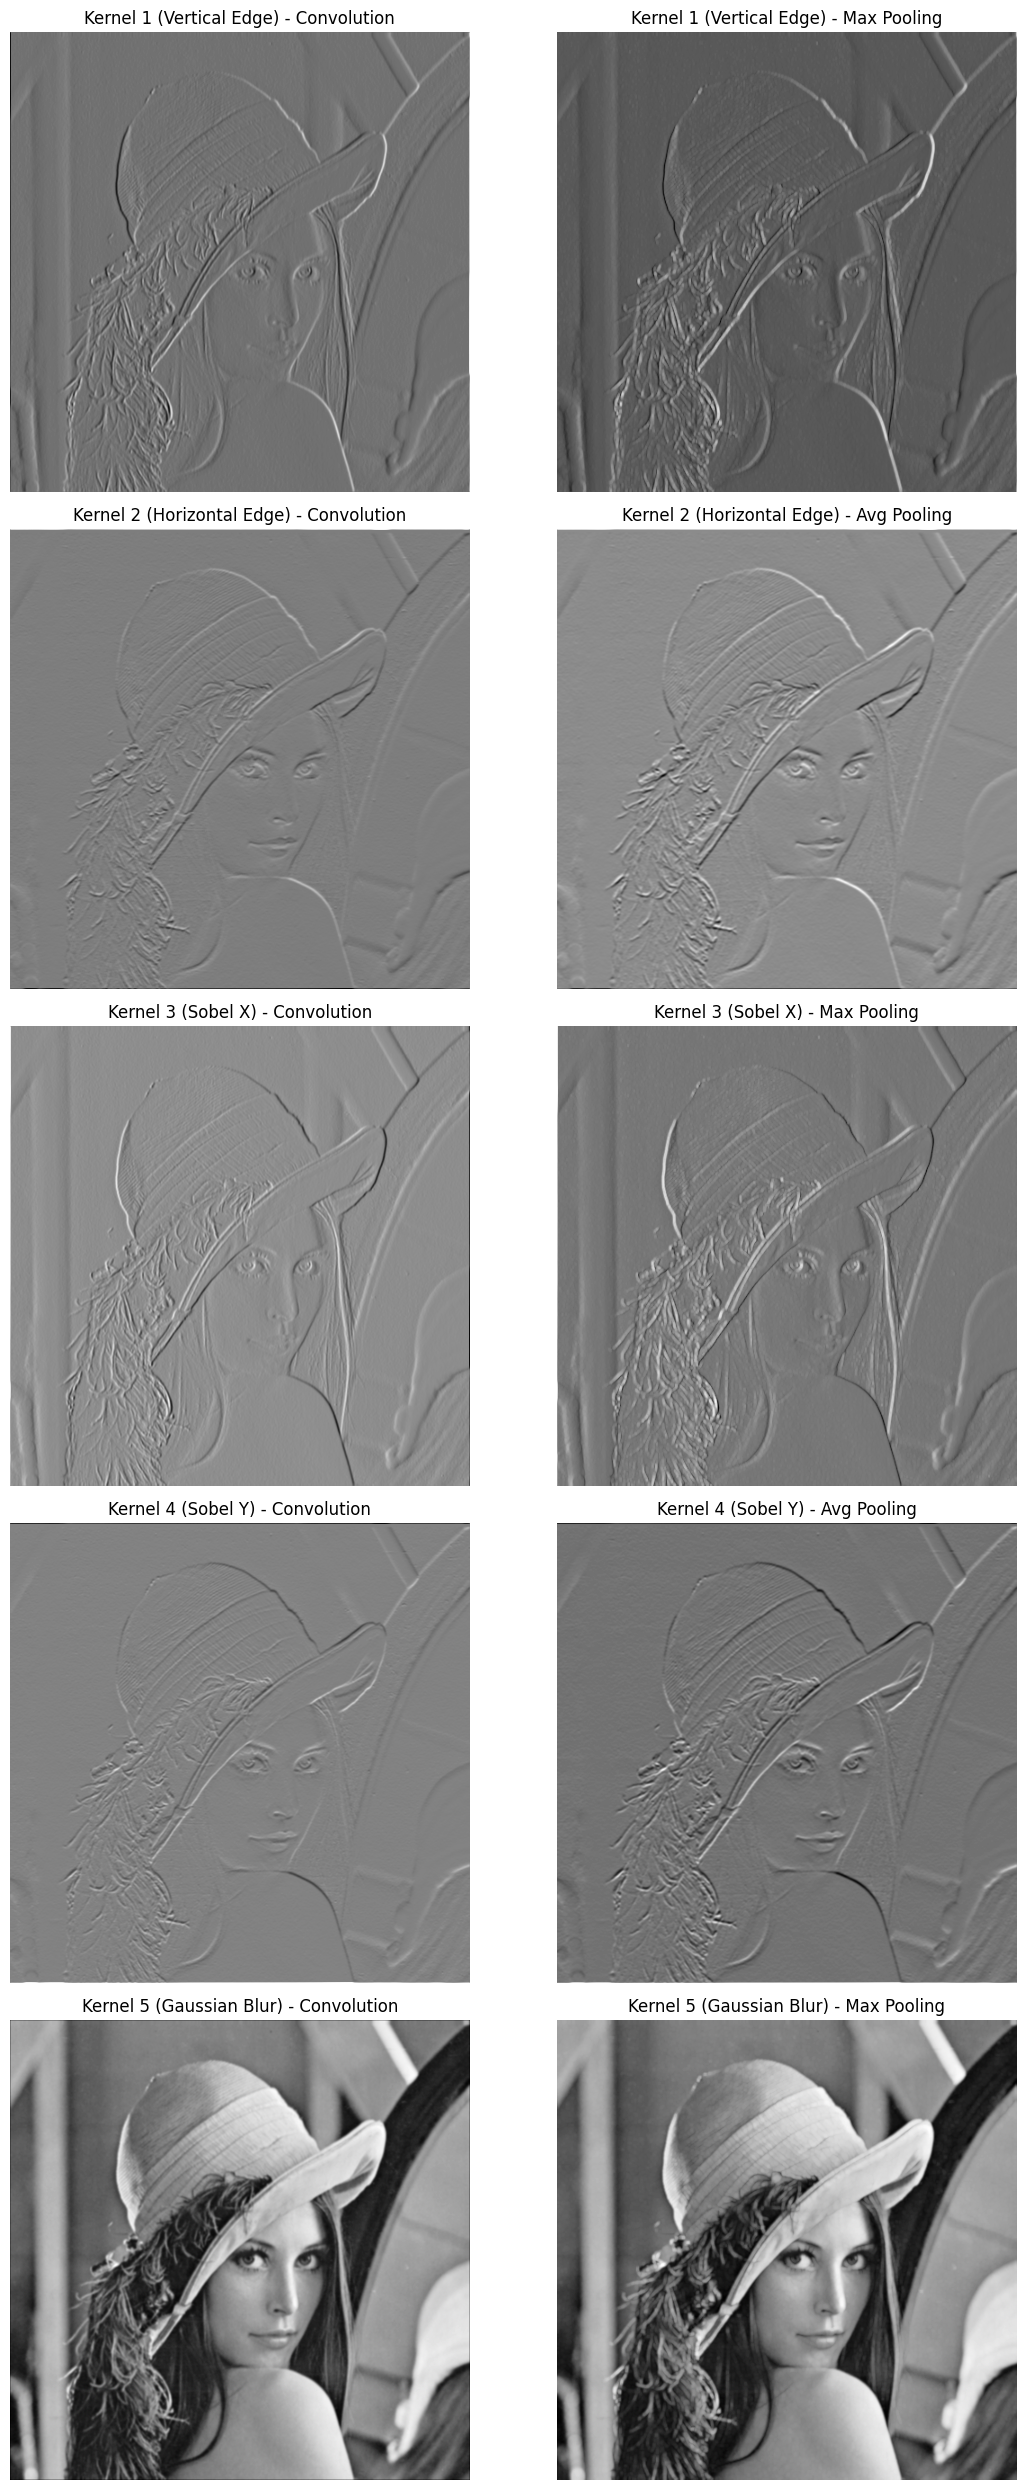

In [8]:
fig, axes = plt.subplots(5, 2, figsize=(12, 25))

# Display results for each kernel
for i, (conv_img, pool_img, title) in enumerate([
    (conv_1, lena_kernel_1_maxpool, "Kernel 1 (Vertical Edge)"),
    (conv_2, lena_kernel_2_avgpool, "Kernel 2 (Horizontal Edge)"),
    (conv_3, lena_kernel_3_maxpool, "Kernel 3 (Sobel X)"),
    (conv_4, lena_kernel_4_avgpool, "Kernel 4 (Sobel Y)"),
    (conv_5, lena_kernel_5_maxpool, "Kernel 5 (Gaussian Blur)")
]):
    # Normalize images for better visualization
    conv_norm = (conv_img - np.min(conv_img)) / (np.max(conv_img) - np.min(conv_img) + 1e-10)
    pool_norm = (pool_img - np.min(pool_img)) / (np.max(pool_img) - np.min(pool_img) + 1e-10)
    
    # Plot convolution result
    axes[i, 0].imshow(conv_norm, cmap='gray')
    axes[i, 0].set_title(f"{title} - Convolution")
    axes[i, 0].axis('off')
    
    # Plot pooling result
    axes[i, 1].imshow(pool_norm, cmap='gray')
    pool_type = "Max Pooling" if i in [0, 2, 4] else "Avg Pooling"
    axes[i, 1].set_title(f"{title} - {pool_type}")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

## Section 2: Using Keras to implement CNN for image classification

This section, unlike the previous projects you are granted full liberty to **build the structure of your model appropriately using keras**. I have provided only the code to download the cifar10 dataset. (Note that cifar10 contains rgb images with 3 channels unlike the grayscake image lena we used earlier.)

**Final expected outcome:** For the best CNN model architecture and parameters you find, **your model is required to be able to provide accurate predictions**. The **accuracy rate will determine your score**. For this **implement a predict function** - instructions given below.

Hint: To improve your model you may use the following techniques.
1. 5-fold cross validation accuracy.
2. Testing accuracy.
3. Confusion matrix of the result.
4. Precision recall for each class.

Test on different hyperparameters and network architectures and select decide the best performer based on the cross-validation accuracy.

In [9]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [10]:
# Preprocess data
x_train = x_train.astype('float32') / 255.0  
x_test = x_test.astype('float32') / 255.0
y_train_cat = to_categorical(y_train, 10) 
y_test_cat = to_categorical(y_test, 10)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [11]:
def create_cnn_model():
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
        MaxPooling2D((2, 2)),

        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [ ]:
# Create and train model
model = create_cnn_model()

history = model.fit(
    x_train,
    y_train_cat,
    batch_size=128,   
    epochs=10,         
    validation_split=0.2,  
    verbose=1
)

# Evaluate performance
val_loss = min(history.history['val_loss'])
val_accuracy = history.history['val_accuracy'][np.argmin(history.history['val_loss'])]

print(f"Validation accuracy: {val_accuracy:.4f}")
print(f"Validation loss: {val_loss:.4f}")
best_model = model

/Users/garthigan.k/Desktop/Academics /Sem 8/Neural Networks/Project 4/keras/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.2577 - loss: 1.9918 - val_accuracy: 0.4693 - val_loss: 1.4911
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.4516 - loss: 1.5103 - val_accuracy: 0.5219 - val_loss: 1.3691
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.4925 - loss: 1.3867 - val_accuracy: 0.5525 - val_loss: 1.2518
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.5428 - loss: 1.2826 - val_accuracy: 0.5878 - val_loss: 1.1686
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.5642 - loss: 1.2136 - val_accuracy: 0.6020 - val_loss: 1.1462
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.5871 - loss: 1.1467 - val_accuracy: 0.6137 - val_loss: 1.0935
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.6027 - loss: 1.1129 - val_accuracy: 0.6270 - val_loss: 1.0557
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.6207 - loss: 1.0676 - val_accu

In [20]:
test_accuracy = model.evaluate(x_test,y_test_cat)[1]
print(f"Test accuracy: {test_accuracy:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6481 - loss: 1.0026
Test accuracy: 0.6431


In [21]:
y_pred = np.argmax(model.predict(x_test), axis=1)
y_true = np.argmax(y_test_cat, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


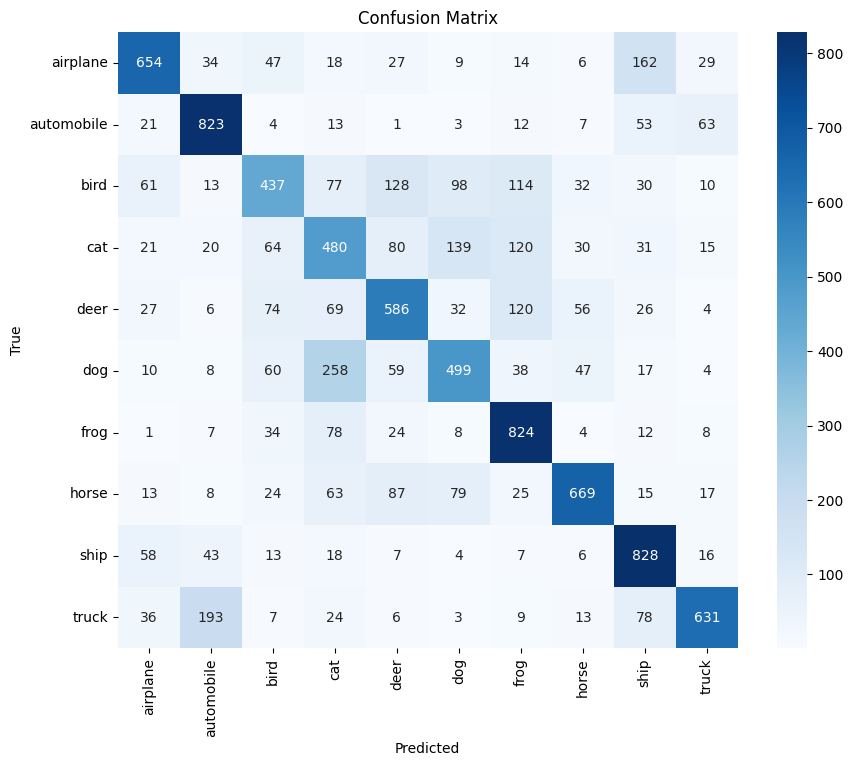

In [22]:
conf_matrix = confusion_matrix(y_true,y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [23]:
report= classification_report(y_true,y_pred,target_names=class_names)
print("Classification Report :\n",report)

Classification Report :
               precision    recall  f1-score   support

    airplane       0.73      0.65      0.69      1000
  automobile       0.71      0.82      0.76      1000
        bird       0.57      0.44      0.50      1000
         cat       0.44      0.48      0.46      1000
        deer       0.58      0.59      0.58      1000
         dog       0.57      0.50      0.53      1000
        frog       0.64      0.82      0.72      1000
       horse       0.77      0.67      0.72      1000
        ship       0.66      0.83      0.74      1000
       truck       0.79      0.63      0.70      1000

    accuracy                           0.64     10000
   macro avg       0.65      0.64      0.64     10000
weighted avg       0.65      0.64      0.64     10000



In [24]:
precision,recall,f1_score , _ = precision_recall_fscore_support(y_true,y_pred,average=None)
for idx , label in enumerate(class_names):
  print(f"{label}: Precision={precision[idx]:.4f}, Recall={recall[idx]:.2f}, F1-Score={f1_score[idx]:.2f}")

airplane: Precision=0.7251, Recall=0.65, F1-Score=0.69
automobile: Precision=0.7126, Recall=0.82, F1-Score=0.76
bird: Precision=0.5720, Recall=0.44, F1-Score=0.50
cat: Precision=0.4372, Recall=0.48, F1-Score=0.46
deer: Precision=0.5831, Recall=0.59, F1-Score=0.58
dog: Precision=0.5709, Recall=0.50, F1-Score=0.53
frog: Precision=0.6422, Recall=0.82, F1-Score=0.72
horse: Precision=0.7690, Recall=0.67, F1-Score=0.72
ship: Precision=0.6613, Recall=0.83, F1-Score=0.74
truck: Precision=0.7917, Recall=0.63, F1-Score=0.70


In [25]:
def predict(test_images):
    
    if isinstance(test_images, torch.Tensor):
        test_images = test_images.cpu().numpy()

    
    if test_images.shape[1] == 3:  
        test_images = np.transpose(test_images, (0, 2, 3, 1))

    
    model = best_model

    
    predict = model.predict(test_images, verbose=0)
    predicted_classes = np.argmax(predict, axis=1)
    predictions = [class_names[idx] for idx in predicted_classes]

    return predictions